In [1]:
import importlib

import indra_gpt.chat_curate.chat_curate
importlib.reload(indra_gpt.chat_curate.chat_curate)
from indra_gpt.chat_curate.chat_curate import *

import indra_gpt.chat_curate.eval
importlib.reload(indra_gpt.chat_curate.eval)
from indra_gpt.chat_curate.eval import *

import pickle
from pathlib import Path

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


/Users/thomaslim/miniconda3/envs/indra_gpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: [2025-07-08 14:49:38] httpx - HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


In [2]:
RESULTS_DIR = Path.cwd().joinpath("output/curated_statements_sample_100")
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir(parents=True)


Get curated statements dataset

In [3]:
# # Get all curated statements
# Filter out the following curated statements:
# 1. Curator is 'thomaslim6793@gmail.com' and the tag is not 'correct'
# 2. All statements where at least one agent is 'CD4' or 'CD8'

curations = indra_db_rest.get_curations()
curation_hashes_to_keep = []

# 1. Curator is 'thomaslim6793@gmail.com' and the tag is not 'correct'
for c in curations:
    if c['curator'] == 'thomaslim6793@gmail.com' and c['tag'] != 'correct':
        continue
    curation_hashes_to_keep.append(c['pa_hash'])

CHUNK_SIZE = 1000
chunks = [curation_hashes_to_keep[i:i + CHUNK_SIZE] for i in range(0, len(curation_hashes_to_keep), CHUNK_SIZE)]

# Get all statements for the curated hashes
stmts = []
for i, chunk in tqdm(enumerate(chunks), total=len(chunks), desc=f"Processing chunk..."):
    stmt_proc = indra_db_rest.get_statements_by_hash(chunk, ev_limit=1000)
    chunk_statements = stmt_proc.statements
    stmts.extend(chunk_statements)

# 2. All statements where at least one agent is None, or at least one agent is 'CD4' or 'CD8'
stmts_filtered = []
for stmt in tqdm(stmts, desc="Filtering statements for non-CD4/CD8 agents"):
    invalid = False
    for agent in stmt.agent_list():
        if not agent:
            print(f"Skipping statement {stmt} due to None agent")
            invalid = True
            break
        if agent.name in ['CD4', 'CD8']:
            invalid = True
            print(f"Skipping statement {stmt} due to agent {agent.name}")
            break
    if invalid:
        continue
    else:
        stmts_filtered.append(stmt)

# Save to pickle
output_path = RESULTS_DIR / 'curated_statements_all_filtered.pkl'

with open(output_path, "wb") as f:
    pickle.dump(stmts_filtered, f)

print(f"✅ Saved {len(stmts_filtered)} curated statements to: {output_path}")


INFO: [2025-07-07 14:52:11] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list
INFO: [2025-07-07 14:52:11] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 14:52:11] indra.sources.indra_db_rest.util - data: None
Processing chunk...:   0%|          | 0/18 [00:00<?, ?it/s]INFO: [2025-07-07 14:52:13] indra_db_rest.query_processor - Retrieving statements that have hash -10099899566048837, -10099899566048837, -10099899566048837, -1024598366423550, -1024598366423550, -1024598366423550, -1024598366423550, -1024598366423550, -1024598366423550, -1024598366423550, -1024598366423550, -1024598366423550, -10261784569381665, -10382554920378281, -10405918370872011, -10418861028177660, -10462085087991775, -10462085087991775, -10601543865672796, -10675072561644979, -10942941480971356, -10942941480971356, -10942941480971356, -10942941480971356, -10942941480971356, -10942941480971356, -10942941480971356, -10942941480971356, -10942941480971356

Skipping statement Activation(IDO1(), CD4()) due to agent CD4
Skipping statement Inhibition(IL15(), CD8()) due to agent CD8
Skipping statement Phosphorylation(None, Tie()) due to None agent
Skipping statement Phosphorylation(None, RAC()) due to None agent
Skipping statement Methylation(None, CDKN2A()) due to None agent
Skipping statement Activation(CD4(), IFNG()) due to agent CD4
Skipping statement Activation(CD8(), IFNG()) due to agent CD8
Skipping statement Activation(IFNG(), CD4()) due to agent CD4
Skipping statement Activation(CD4(), TNF()) due to agent CD4
Skipping statement Activation(IL10(), CD8()) due to agent CD8
Skipping statement Activation(CD8(), IL10()) due to agent CD8
Skipping statement Phosphorylation(None, CTSL()) due to None agent
Skipping statement Inhibition(hydroxychloroquine(), CD4()) due to agent CD4
Skipping statement DecreaseAmount(None, antimicrobial agent()) due to None agent
Skipping statement IncreaseAmount(None, PPE1()) due to None agent
Skipping statement

Get curation statement sample where each statement has at least n_evidence evidences

In [3]:
curated_statements_all = pickle.load(open(RESULTS_DIR.joinpath("curated_statements_all_filtered.pkl"), "rb"))

n_evidence = 10

curated_statements_min_evidence = []
for stmt in curated_statements_all:
    if len(stmt.evidence) >= n_evidence:
        # also make sure that all evidence has text
        if all(ev.text for ev in stmt.evidence):
            curated_statements_min_evidence.append(stmt)

# Sample 100 statements
rng = random.Random(42)  # For reproducibility
curated_statements_min_evidence_sample = rng.sample(curated_statements_min_evidence, min(100, len(curated_statements_min_evidence)))

# Save to pickle
output_path = RESULTS_DIR / f"curated_statements_min_evidence_{n_evidence}_sample_100.pkl"

with open(output_path, "wb") as f:
    pickle.dump(curated_statements_min_evidence_sample, f)

print(f"✅ Saved {len(curated_statements_min_evidence_sample)} curated statements to: {output_path}")


✅ Saved 100 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/curated_statements_min_evidence_10_sample_100.pkl


Double check that the sample curation statements are valid

In [5]:
# Double check that the sample is correct
with open(RESULTS_DIR / f"curated_statements_min_evidence_10_sample_100.pkl", "rb") as f:
    curated_statements = pickle.load(f)

# First check that every statement has at least 10 evidences
for stmt in curated_statements:
    if len(stmt.evidence) < n_evidence:
        print(f"Statement {stmt} has less than {n_evidence} evidences: {len(stmt.evidence)}")
    if not all(ev.text for ev in stmt.evidence):
        print(f"Statement {stmt} has evidence without text")

# Second check that the sample is 100
if len(curated_statements) != 100:
    print(f"Sample size is not 100, it is {len(curated_statements)}")

# Third check that the sample is unique
unique_hashes = set()
for stmt in curated_statements:
    if stmt.get_hash() in unique_hashes:
        print(f"Duplicate statement found: {stmt.get_hash()}")
    unique_hashes.add(stmt.get_hash())

# Finally check that the statement is curated, and that if the curator is
# 'thomaslim6793@gmail.com' that the tag is 'correct'
curations = indra_db_rest.get_curations()
curation_hashes = set(c['pa_hash'] for c in curations)
for stmt in curated_statements:
    if stmt.get_hash() not in curation_hashes:
        print(f"Statement {stmt} is not curated")
    else:
        curation = next(c for c in curations if c['pa_hash'] == stmt.get_hash())
        if curation['curator'] == 'thomaslim6793@gmail.com' and curation['tag'] != 'correct':
            print(f"Statement {stmt} is curated by {curation['curator']} but tagged as {curation['tag']}")


INFO: [2025-07-07 15:00:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list
INFO: [2025-07-07 15:00:38] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 15:00:38] indra.sources.indra_db_rest.util - data: None


Run LLM curation

In [6]:
models = ['gpt-4o-mini']
for model in models:
    for n_evidence_to_curate in [2, 4, 6, 8, 10]:
        print(f"Curating statements with {n_evidence_to_curate} evidences using model: {model}")
        # Now curate the statements using the chat model
        llm_curations_binary = chat_curate_stmts(curated_statements,
                                        n_evidence_to_curate=n_evidence_to_curate,
                                        decision_threshold=0.5,
                                        binary_classification=True,
                                        #ignore_tags=['incorrect'],
                                        n_fewshot_examples=2,
                                        get_ex_per_tag=True,
                                        schema_output_mode=True,
                                        model=model)
        llm_curations_multiclass = chat_curate_stmts(curated_statements,
                                        n_evidence_to_curate=n_evidence_to_curate,
                                        decision_threshold=0.5,
                                        binary_classification=False,
                                        ignore_tags=['incorrect'],
                                        n_fewshot_examples=2,
                                        get_ex_per_tag=True,
                                        schema_output_mode=True,
                                        model=model)

        if not RESULTS_DIR.joinpath(model).joinpath(f"num_evidence_{n_evidence_to_curate}").exists():
            RESULTS_DIR.joinpath(model).joinpath(f"num_evidence_{n_evidence_to_curate}").mkdir(parents=True)
        with open(RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}" / "chat_curation_binary_classification.json", "w") as f:
            json.dump(llm_curations_binary, f, indent=2)
        with open(RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}" / "chat_curation_multiclass_classification.json", "w") as f:
            json.dump(llm_curations_multiclass, f, indent=2)


Curating statements with 2 evidences using model: gpt-4o-mini


INFO: [2025-07-07 15:01:25] indra_gpt.chat_curate.chat_curate - Loaded 32542718 definitions into cache.
Generating prompts...:  84%|████████▍ | 84/100 [01:23<00:12,  1.23it/s]INFO: [2025-07-07 15:02:56] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:02:57] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
Sending prompts to LLM:   0%|          | 0/100 [00:00<?, ?it/s]15:03:07 - LiteLLM:INFO: utils.py:2931 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO: [2025-07-07 15:03:07] LiteLLM - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO: [2025-07-07 15:03:08] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
15:03:08 - LiteLLM:INFO: utils.py:1213 - Wrapper: Completed Call, calling success_handler
INFO: [2025-07-07 15:03:08] LiteLLM - Wra

Curating statements with 4 evidences using model: gpt-4o-mini


INFO: [2025-07-07 15:11:52] indra_gpt.chat_curate.chat_curate - Loaded 32542718 definitions into cache.
Generating prompts...:  84%|████████▍ | 84/100 [02:00<00:25,  1.61s/it]INFO: [2025-07-07 15:14:00] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:14:00] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:14:00] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:14:00] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
Sending prompts to LLM:   0%|          | 0/100 [00:00<?, ?it/s]15:14:20 - LiteLLM:INFO: utils.py:2931 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO: [2025-07-07 15:14:20] L

Curating statements with 6 evidences using model: gpt-4o-mini


INFO: [2025-07-07 15:28:35] indra_gpt.chat_curate.chat_curate - Loaded 32542718 definitions into cache.
Generating prompts...:  84%|████████▍ | 84/100 [02:57<00:39,  2.44s/it]INFO: [2025-07-07 15:31:39] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:31:39] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:31:39] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:31:40] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:31:40] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:31:40] indra_g

Curating statements with 8 evidences using model: gpt-4o-mini


INFO: [2025-07-07 15:52:30] indra_gpt.chat_curate.chat_curate - Loaded 32542718 definitions into cache.
Generating prompts...:  84%|████████▍ | 84/100 [03:58<00:51,  3.20s/it]INFO: [2025-07-07 15:56:36] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:56:36] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:56:36] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:56:36] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:56:36] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 15:56:37] indra_g

Curating statements with 10 evidences using model: gpt-4o-mini


INFO: [2025-07-07 16:23:36] indra_gpt.chat_curate.chat_curate - Loaded 32542718 definitions into cache.
Generating prompts...:  84%|████████▍ | 84/100 [04:54<01:04,  4.03s/it]INFO: [2025-07-07 16:28:38] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 16:28:38] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 16:28:38] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 16:28:38] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 16:28:39] indra_gpt.chat_curate.chat_curate - Skipping agent Ad() with no grounding: sequence item 0: expected str instance, NoneType found
INFO: [2025-07-07 16:28:39] indra_g

In [ ]:
# Evaluate the curated statements
evidence_counts = [2, 4, 6, 8, 10]

for model in models:
    for n_evidence_to_curate in evidence_counts:
        base_path = RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}"

        with open(base_path / "chat_curation_binary_classification.json", "r") as f:
            chat_curation_binary_classification = json.load(f)
        with open(base_path / "chat_curation_multiclass_classification.json", "r") as f:
            chat_curation_multiclass_classification = json.load(f)

        # Evaluate and save comparison
        eval_stmt_binary = curation_statement_comparison_json(chat_curation_binary_classification)
        with open(base_path / "eval_stmt_chat_curation_binary_classification.json", "w") as f:
            json.dump(eval_stmt_binary, f, indent=2)

        eval_stmt_multi = curation_statement_comparison_json(chat_curation_multiclass_classification)
        with open(base_path / "eval_stmt_chat_curation_multiclass_classification.json", "w") as f:
            json.dump(eval_stmt_multi, f, indent=2)


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-07 22:43:20] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/8621240135402808
INFO: [2025-07-07 22:43:20] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:43:20] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:41,  2.40it/s]INFO: [2025-07-07 22:43:21] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/33241402993253896
INFO: [2025-07-07 22:43:21] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:43:21] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:34,  2.82it/s]INFO: [2025-07-07 22:43:21] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/20074216280555808
INFO: [2025-07-07 22:43:21] indra.sources.indra_db_rest.util - params: {'api_key'


Model: gpt-4o-mini, Num Evidence: 2
binary_classification - Accuracy: 0.8600
multiclass_classification - Accuracy: 0.8100


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-07 22:44:29] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/8621240135402808
INFO: [2025-07-07 22:44:29] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:44:29] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:27,  3.55it/s]INFO: [2025-07-07 22:44:29] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/33241402993253896
INFO: [2025-07-07 22:44:29] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:44:29] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:32,  3.01it/s]INFO: [2025-07-07 22:44:30] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/20074216280555808
INFO: [2025-07-07 22:44:30] indra.sources.indra_db_rest.util - params: {'api_key'


Model: gpt-4o-mini, Num Evidence: 4
binary_classification - Accuracy: 0.8300
multiclass_classification - Accuracy: 0.8100


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/8621240135402808
INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:27,  3.58it/s]INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/33241402993253896
INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:27,  3.60it/s]INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/20074216280555808
INFO: [2025-07-07 22:45:38] indra.sources.indra_db_rest.util - params: {'api_key'


Model: gpt-4o-mini, Num Evidence: 6
binary_classification - Accuracy: 0.8500
multiclass_classification - Accuracy: 0.8300


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/8621240135402808
INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:27,  3.57it/s]INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/33241402993253896
INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:27,  3.56it/s]INFO: [2025-07-07 22:46:46] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/20074216280555808
INFO: [2025-07-07 22:46:47] indra.sources.indra_db_rest.util - params: {'api_key'


Model: gpt-4o-mini, Num Evidence: 8
binary_classification - Accuracy: 0.8300
multiclass_classification - Accuracy: 0.8200


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-07 22:47:56] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/8621240135402808
INFO: [2025-07-07 22:47:56] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:47:56] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:27,  3.54it/s]INFO: [2025-07-07 22:47:56] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/33241402993253896
INFO: [2025-07-07 22:47:56] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 22:47:56] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:28,  3.43it/s]INFO: [2025-07-07 22:47:57] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/20074216280555808
INFO: [2025-07-07 22:47:57] indra.sources.indra_db_rest.util - params: {'api_key'


Model: gpt-4o-mini, Num Evidence: 10
binary_classification - Accuracy: 0.8600
multiclass_classification - Accuracy: 0.8100


binary_classification - Accuracy: 0.8600
multiclass_classification - Accuracy: 0.8100
binary_classification - Accuracy: 0.8300
multiclass_classification - Accuracy: 0.8100
binary_classification - Accuracy: 0.8500
multiclass_classification - Accuracy: 0.8300
binary_classification - Accuracy: 0.8300
multiclass_classification - Accuracy: 0.8200
binary_classification - Accuracy: 0.8600
multiclass_classification - Accuracy: 0.8100


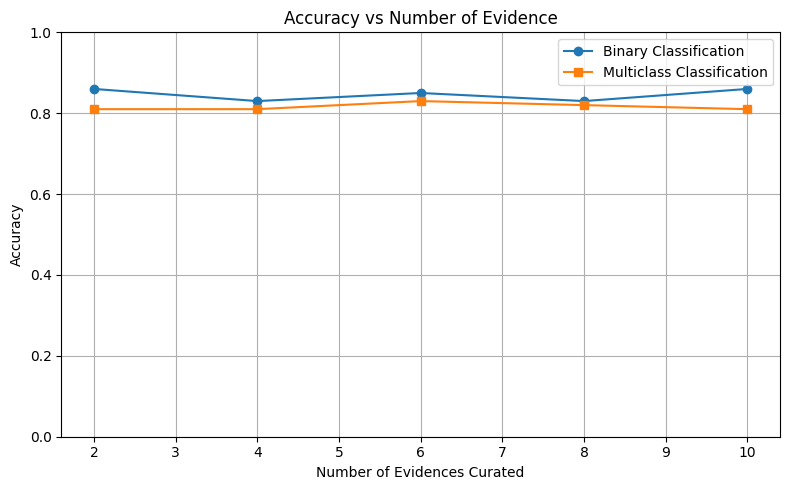

In [ ]:
# Plot accuracy vs number of evidence curated
accuracy_data = {model: {'binary': [], 'multiclass': []} for model in models}
evidence_counts = [2, 4, 6, 8, 10]
for model in models:
    for n_evidence_to_curate in evidence_counts:
        base_path = RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}"
        for eval_strat, label in [('binary_classification', 'binary'), ('multiclass_classification', 'multiclass')]:
            with open(base_path / f"eval_stmt_chat_curation_{eval_strat}.json", "r") as f:
                res = json.load(f)
            preds = [item['llm_overall_prediction'] for item in res]
            labels = [item['indra_curation'] for item in res]
            acc = accuracy_score(labels, preds)
            accuracy_data[model][label].append(acc)
            print(f"{eval_strat} - Accuracy: {acc:.4f}")

# Plotting
n_evidence = len(evidence_counts)

# Compute average accuracy across models for each task
binary_accuracy = [x for x in accuracy_data[model]['binary']]
multiclass_accuracy = [x for x in accuracy_data[model]['multiclass']]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(evidence_counts, binary_accuracy, marker='o', label='Binary Classification')
plt.plot(evidence_counts, multiclass_accuracy, marker='s', label='Multiclass Classification')

plt.title("Accuracy vs Number of Evidence")
plt.xlabel("Number of Evidences Curated")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Set num_evidence = 10, parametrize over proportion_correct ranging from 0.1 ~ 1.0 ROC curve to get precision and recall.

In [67]:
# Evaluate the curated statements with different decision thresholds
DIR = Path.cwd().joinpath("output/curated_statements_sample_100")

models = ['gpt-4o-mini']
decision_thresholds = np.arange(0.0, 1.11, 0.1)

for model in models:

    with open(DIR / model / "num_evidence_10" / "chat_curation_binary_classification.json", "r") as f:
        chat_curation_binary_classification = json.load(f)

    with open(DIR / model / "num_evidence_10" / "chat_curation_multiclass_classification.json", "r") as f:
        chat_curation_multiclass_classification = json.load(f)

    for decision_threshold in decision_thresholds:
        for key, val in chat_curation_binary_classification['pa_hashes_dict'].items():
            if val['proportion_correct'] >= decision_threshold:
                val['overall_prediction'] = 'correct'
            else:
                val['overall_prediction'] = 'incorrect'
        for key, val in chat_curation_multiclass_classification['pa_hashes_dict'].items():
            if val['proportion_correct'] >= decision_threshold:
                val['overall_prediction'] = 'correct'
            else:
                val['overall_prediction'] = 'incorrect'

        threshold_str = f"{decision_threshold:.1f}".replace(".", "_")
        base_path = DIR / model / "decision_thresholds" / threshold_str
        if not base_path.exists():
            base_path.mkdir(parents=True)

        # Evaluate and save comparison
        eval_stmt_binary = curation_statement_comparison_json(chat_curation_binary_classification)
        with open(base_path / "eval_stmt_chat_curation_binary_classification.json", "w") as f:
            json.dump(eval_stmt_binary, f, indent=2)

        eval_stmt_multi = curation_statement_comparison_json(chat_curation_multiclass_classification)
        with open(base_path / "eval_stmt_chat_curation_multiclass_classification.json", "w") as f:
            json.dump(eval_stmt_multi, f, indent=2)


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-07 23:33:42] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/8621240135402808
INFO: [2025-07-07 23:33:42] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 23:33:42] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<01:04,  1.53it/s]INFO: [2025-07-07 23:33:43] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/33241402993253896
INFO: [2025-07-07 23:33:43] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-07 23:33:43] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:42,  2.33it/s]INFO: [2025-07-07 23:33:43] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/20074216280555808
INFO: [2025-07-07 23:33:43] indra.sources.indra_db_rest.util - params: {'api_key'


Model: gpt-4o-mini, threshold: 0.0
binary_classification - Accuracy: 0.7100
multiclass_classification - Accuracy: 0.7100

Model: gpt-4o-mini, threshold: 0.1
binary_classification - Accuracy: 0.8000
multiclass_classification - Accuracy: 0.8000

Model: gpt-4o-mini, threshold: 0.2
binary_classification - Accuracy: 0.8200
multiclass_classification - Accuracy: 0.8100

Model: gpt-4o-mini, threshold: 0.3
binary_classification - Accuracy: 0.8500
multiclass_classification - Accuracy: 0.8400

Model: gpt-4o-mini, threshold: 0.4
binary_classification - Accuracy: 0.8500
multiclass_classification - Accuracy: 0.8400

Model: gpt-4o-mini, threshold: 0.5
binary_classification - Accuracy: 0.8600
multiclass_classification - Accuracy: 0.8100

Model: gpt-4o-mini, threshold: 0.6
binary_classification - Accuracy: 0.8300
multiclass_classification - Accuracy: 0.7300

Model: gpt-4o-mini, threshold: 0.7
binary_classification - Accuracy: 0.7900
multiclass_classification - Accuracy: 0.6100

Model: gpt-4o-mini, thr

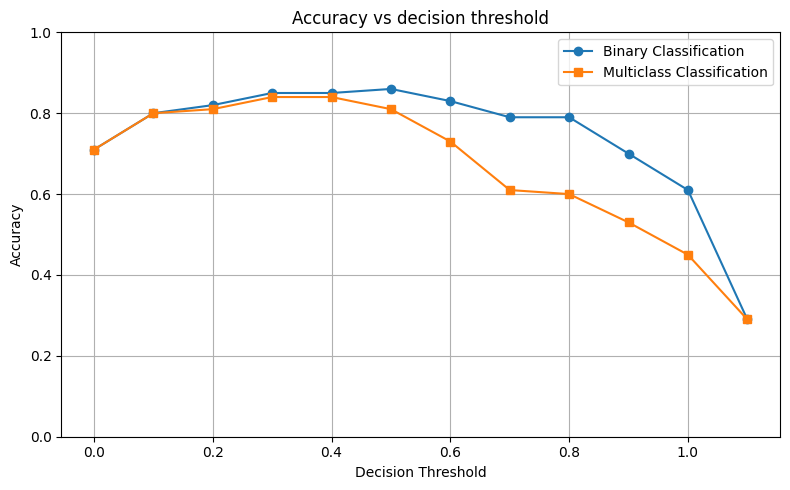

In [68]:
# Plot accuracy vs decision threshold
accuracy_data = {model: {'binary': [], 'multiclass': []} for model in models}
decision_thresholds = np.arange(0.0, 1.11, 0.1)
DIR = Path.cwd().joinpath("output/curated_statements_sample_100")
for model in models:
    for decision_threshold in decision_thresholds:
        threshold_str = f"{decision_threshold:.1f}".replace(".", "_")
        base_path = DIR / model / "decision_thresholds" / threshold_str
        print(f"\nModel: {model}, threshold: {decision_threshold:.1f}")
        for eval_strat, label in [('binary_classification', 'binary'), ('multiclass_classification', 'multiclass')]:
            with open(base_path / f"eval_stmt_chat_curation_{eval_strat}.json", "r") as f:
                res = json.load(f)
            preds = [item['llm_overall_prediction'] for item in res]
            labels = [item['indra_curation'] for item in res]
            acc = accuracy_score(labels, preds)
            accuracy_data[model][label].append(acc)
            print(f"{eval_strat} - Accuracy: {acc:.4f}")

# Plotting
n_evidence = len(evidence_counts)

# Compute average accuracy across models for each task
bin_accuracy = [x for x in accuracy_data[model]['binary']]
multi_accuracy = [x for x in accuracy_data[model]['multiclass']]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(decision_thresholds, bin_accuracy, marker='o', label='Binary Classification')
plt.plot(decision_thresholds, multi_accuracy, marker='s', label='Multiclass Classification')

plt.title("Accuracy vs decision threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [69]:
from sklearn.metrics import confusion_matrix

# Initialize
eval_data = {
    model: {
        round(thresh, 2): {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        for thresh in decision_thresholds
    }
    for model in models
}

for model in models:
    for decision_threshold in decision_thresholds:
        threshold_str = f"{decision_threshold:.1f}".replace(".", "_")
        base_path = RESULTS_DIR / model / "decision_thresholds" / threshold_str

        # Load evaluated results
        with open(base_path / "eval_stmt_chat_curation_binary_classification.json", "r") as f:
            res = json.load(f)

        # Get predictions and labels
        preds = [item['llm_overall_prediction'] for item in res]
        labels = [item['indra_curation'] for item in res]

        # Compute confusion matrix
        cm = confusion_matrix(labels, preds, labels=['correct', 'incorrect'])
        tp, fn, fp, tn = cm.ravel()

        eval_data[model][round(decision_threshold, 2)] = {
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn
        }

        print(f"Threshold {decision_threshold:.1f} — TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")


Threshold 0.0 — TP: 71, TN: 0, FP: 29, FN: 0
Threshold 0.1 — TP: 70, TN: 10, FP: 19, FN: 1
Threshold 0.2 — TP: 70, TN: 12, FP: 17, FN: 1
Threshold 0.3 — TP: 67, TN: 18, FP: 11, FN: 4
Threshold 0.4 — TP: 67, TN: 18, FP: 11, FN: 4
Threshold 0.5 — TP: 65, TN: 21, FP: 8, FN: 6
Threshold 0.6 — TP: 59, TN: 24, FP: 5, FN: 12
Threshold 0.7 — TP: 53, TN: 26, FP: 3, FN: 18
Threshold 0.8 — TP: 53, TN: 26, FP: 3, FN: 18
Threshold 0.9 — TP: 43, TN: 27, FP: 2, FN: 28
Threshold 1.0 — TP: 33, TN: 28, FP: 1, FN: 38
Threshold 1.1 — TP: 0, TN: 29, FP: 0, FN: 71


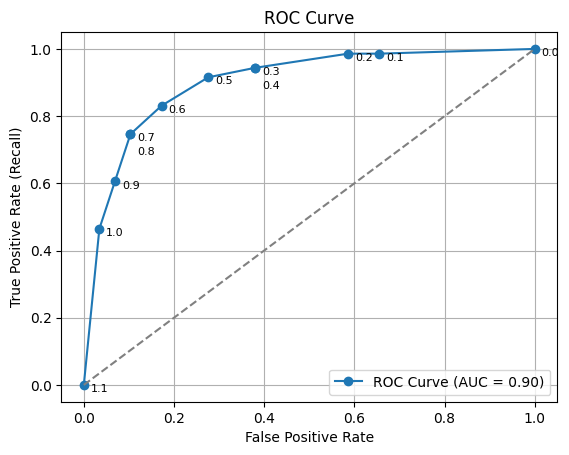

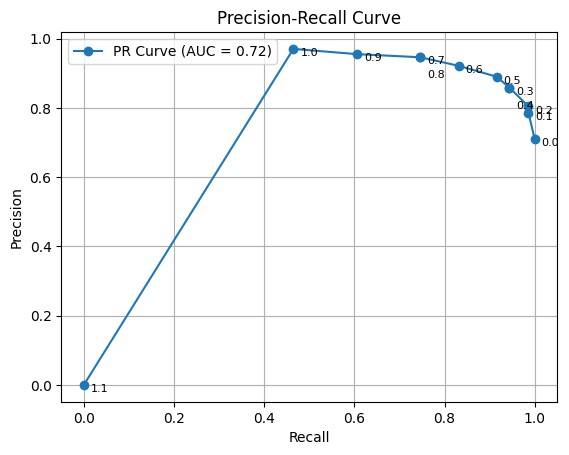

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from collections import defaultdict

# Prepare data
for model in models:
    fpr, tpr, precision, recall, thresholds = [], [], [], [], []

    for threshold, vals in sorted(eval_data[model].items()):
        TP = vals['TP']
        TN = vals['TN']
        FP = vals['FP']
        FN = vals['FN']

        tpr_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr_val = FP / (FP + TN) if (FP + TN) > 0 else 0
        precision_val = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_val = tpr_val

        fpr.append(fpr_val)
        tpr.append(tpr_val)
        precision.append(precision_val)
        recall.append(recall_val)
        thresholds.append(threshold)

    # AUC
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    # Helper to spread overlapping labels
    def annotate_points(x_vals, y_vals, thresh_vals, xlabel, ylabel, title, curve_label, auc_val):
        seen_coords = defaultdict(int)
        plt.figure()
        plt.plot(x_vals, y_vals, marker='o', label=f'{curve_label} (AUC = {auc_val:.2f})')
        for x, y, th in zip(x_vals, y_vals, thresh_vals):
            key = (round(x, 4), round(y, 4))
            count = seen_coords[key]
            dx = 5
            dy = -5 + (count * -10)  # offset each repeated label downward
            seen_coords[key] += 1
            plt.annotate(f'{th:.1f}', (x, y), textcoords="offset points", xytext=(dx, dy), fontsize=8)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray') if xlabel == 'False Positive Rate' else None
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot ROC with offset annotations
    annotate_points(
        fpr, tpr, thresholds,
        xlabel='False Positive Rate',
        ylabel='True Positive Rate (Recall)',
        title='ROC Curve',
        curve_label='ROC Curve',
        auc_val=roc_auc
    )

    # Plot PR with offset annotations
    annotate_points(
        recall, precision, thresholds,
        xlabel='Recall',
        ylabel='Precision',
        title='Precision-Recall Curve',
        curve_label='PR Curve',
        auc_val=pr_auc
    )
